In [1]:
import pandas as pd
import numpy as np
from indicina.loader import load_data_batch
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
TICKERS = ["BTCUSDT", "ETHUSDT", "XRPUSDT", "ADAUSDT", "BNBUSDT", "TRXUSDT", "NEOUSDT", "EOSUSDT", "LTCUSDT", "ETCUSDT"]
EXCHANGE = "binance_spot"

In [12]:
data_dict = load_data_batch(TICKERS, EXCHANGE, "1D")

In [26]:
data_dict["weights"] = data_dict["close"].pct_change(28)
data_dict["weights"] /= np.exp(data_dict["close"].pct_change(1).rolling(28).std())

data_dict["weights"] = (data_dict["weights"].T - data_dict["weights"].mean(1)).T
data_dict["weights"] = (data_dict["weights"].T / np.abs(data_dict["weights"]).sum(1)).T

data_dict["weights"] = (data_dict["weights"].T * (~np.isnan(data_dict["weights"])).sum(1)).T

In [5]:
def run_backtest(data_dict, rebalance_period, comission_rate, from_date, to_date="2100-01-01"):
    prices = data_dict["close"].fillna(0)
    weights = data_dict["weights"].fillna(0)
    prices = prices.reindex(weights.index)
    
    indexes = prices.resample(rebalance_period).last()[from_date:to_date].index
    
    total_ret = None
    
    old_weight = weights.iloc[0] * 0
    
    for i in range(0, len(indexes) - 1):
        returns = prices[indexes[i]:indexes[i + 1]][1:]
        returns = returns / returns.iloc[0]

        weight = weights[indexes[i]:indexes[i+1]].iloc[1]
        if np.abs(weight.values).sum() == 0:
            continue
        turnover = np.abs(weight.values - old_weight.values)
        turnover = turnover.sum()
        comission = turnover * comission_rate
        
        batch_ret = 1 + (returns * weight - weight)
        mask = ~np.isnan(returns.iloc[0])
        tickers = [weight.index[i] for i in range(len(mask)) if mask[i]]
        batch_ret = batch_ret[tickers].mean(1)
        total_ret = batch_ret \
            if total_ret is None \
            else pd.concat((total_ret, total_ret[-1] * batch_ret * (1 - comission)), axis=0)
        old_weight = weight
    
    return total_ret
    

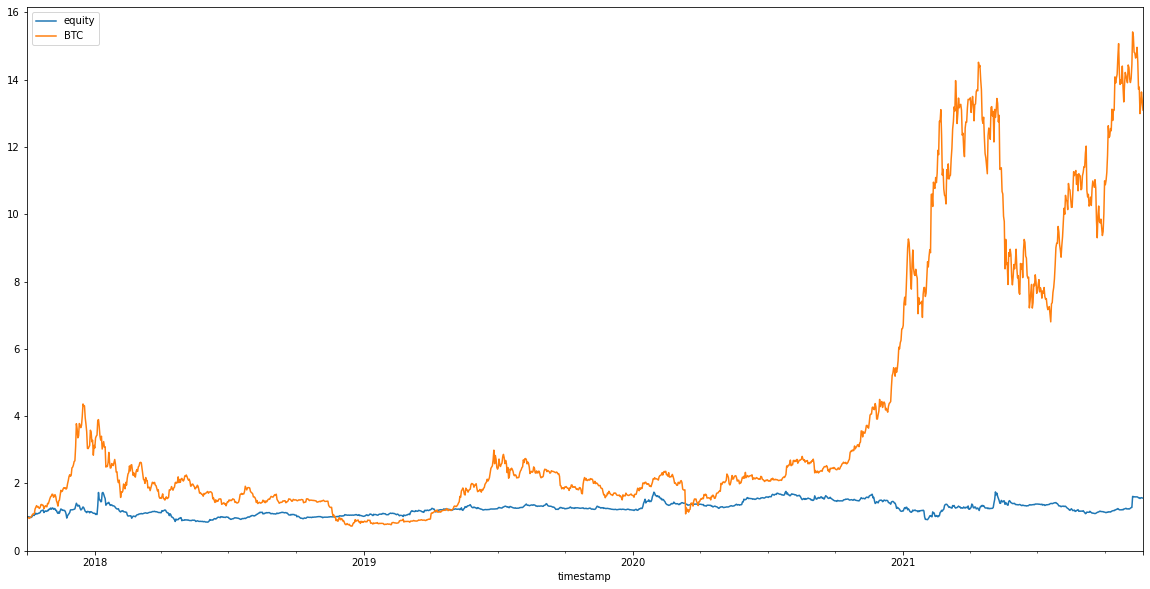

In [27]:
equity = run_backtest(data_dict, "M", 0, "2017", "2022-1")
btcusdt = data_dict["close"]["BTCUSDT"].reindex(equity.index)
btcusdt = btcusdt / btcusdt[0]

plt.figure(figsize=(20, 10))
equity.plot(label="equity")
btcusdt.plot(label="BTC")
plt.legend()

<AxesSubplot:xlabel='timestamp'>

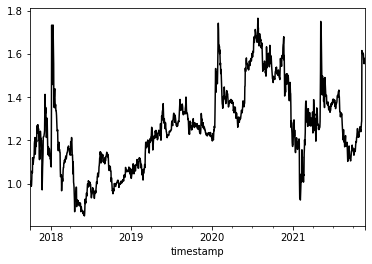

In [28]:
equity.plot(color="black")